# Denoising Diffusion Probabilistic Models

https://arxiv.org/abs/2006.11239 - Paper to replicate

## Define diffusion model

In [188]:
## Standard libraries
import os
import math
import numpy as np 
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
# Set Seaborn style
sns.set(style='darkgrid', font_scale=1.2)
from sklearn.datasets import make_moons

## Progress bar
from tqdm.notebook import tqdm

import torch
print("Using torch", torch.__version__)
#torch.manual_seed(42) # Setting the seed
import torch.nn as nn

Using torch 1.13.1


In [189]:
class Diffuser:
    def __init__(self, num_timesteps=200, beta_range=(0.0001, 0.02), reverse_noise=0.1, device='cuda'):
        self.device = device
        self.T = num_timesteps
        self.betas = torch.linspace(beta_range[0], beta_range[1], num_timesteps)
        self.sigma_t = reverse_noise
        self.set_constants()

    def set_constants(self):
        self.alphas = 1. - self.betas
        self.oneminus_alpha = torch.tensor(1. - self.alphas, device=self.device)
        self.alpha_bar = torch.cumprod(self.alphas, dim=0).to(self.device)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar).to(self.device)
        self.sqrt_alpha_reciprocal = (1. / torch.sqrt(self.alphas)).to(self.device)
        self.sqrt_1minus_alpha_bar = torch.sqrt(1 - self.alpha_bar).to(self.device)

    def forwards_diffusion(self, x0, t):
        # 1. Sample from the standard gaussian --> mean = 0, var = I
        noise = torch.randn_like(x0, device=self.device)

        # 2. Multiply to change standard deviation --> mean = 0 var = (1-alpha_bar) * I
        sample = self.sqrt_1minus_alpha_bar[t] * noise

        # 3. Bias it to increase mean --> mean = sqrt(alpha_bar)*x0, var = (1-alpha_bar) * I
        sample += (self.sqrt_alpha_bar[t] * x0) # noise + mean

        return sample.float(), noise.float()
    
    def training_step(self, model, X, optimiser, loss_fn, current_epoch):
        total_loss = 0.0
        tqdm_obj = tqdm(X, desc=f'Epoch [{current_epoch}]', dynamic_ncols=True)

        for x0 in tqdm_obj: 
            t = torch.randint(0, self.T, (1,), device = self.device) # Sample a time
            x_t, noise = self.forwards_diffusion(x0, t) # Get noisy image at time t in the diffusion schedule

            # 1. Forward pass
            pred_noise = model(x_t, t)

            # 2. Calc loss as given in paper, (i.e. between real noisy sample, and parametised noisy sample)
            loss = loss_fn(noise, pred_noise)

            # 3. Optimiser zero-grad
            optimiser.zero_grad()

            # 4. Backpropagation
            loss.backward()

            # 5. Update -- gradient ascent
            optimiser.step() 

            total_loss += loss.item()
        
        # Returns an avg loss
        return total_loss / len(X)
    
    def reverse_diffusion(self, model, num_samples=100):
        # Sample x_T from the standard Gaussian distribution as a scalar tensor
        X_t = torch.randn(size=(num_samples, 2), device=self.device)
        X_0 = torch.zeros_like(X_t, device=self.device)

        for i, x_t in enumerate(X_t):
            
            # Reverse the diffusion process -- pass through all the latent spaces until we get back to x0
            for t in range(self.T):
                z = torch.randn_like(x_t, device=self.device) if t > 1 else torch.zeros_like(x_t, device=self.device)
                time_step = torch.tensor([self.T - 1 - t], device=self.device)

                x_t = (
                    self.sqrt_alpha_reciprocal[time_step] *
                    (x_t - (self.oneminus_alpha[time_step] / self.sqrt_1minus_alpha_bar[time_step]) * model(x_t, time_step)) +
                    self.sigma_t * z
                ).squeeze(0)

            # Place x_t into the X_0 tensor at the correct index
            X_0[i] = x_t

        return X_0



In [190]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim, output_dim, num_timesteps, embed_dim=4):
        super().__init__()
        
        # 'Attach' a time onto our input data
        self.embedding = nn.Embedding(num_timesteps, embed_dim)

        # Layer stack
        self.layers = nn.Sequential(
            nn.Linear(input_dim + embed_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    
    def forward(self, X, t):
        # Apply embedding to 't'
        t_embedded = self.embedding(t)
        X = X.unsqueeze(0)  # Convert X from shape [1] to [1, 1]
        X_embedded = torch.cat([X, t_embedded], dim=1)  # Concatenate along dimension 1
        
        return self.layers(X_embedded).t()


## Visualising and generating

/home/pr478@ad.eng.cam.ac.uk/anaconda3/envs/score_based_flows/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])


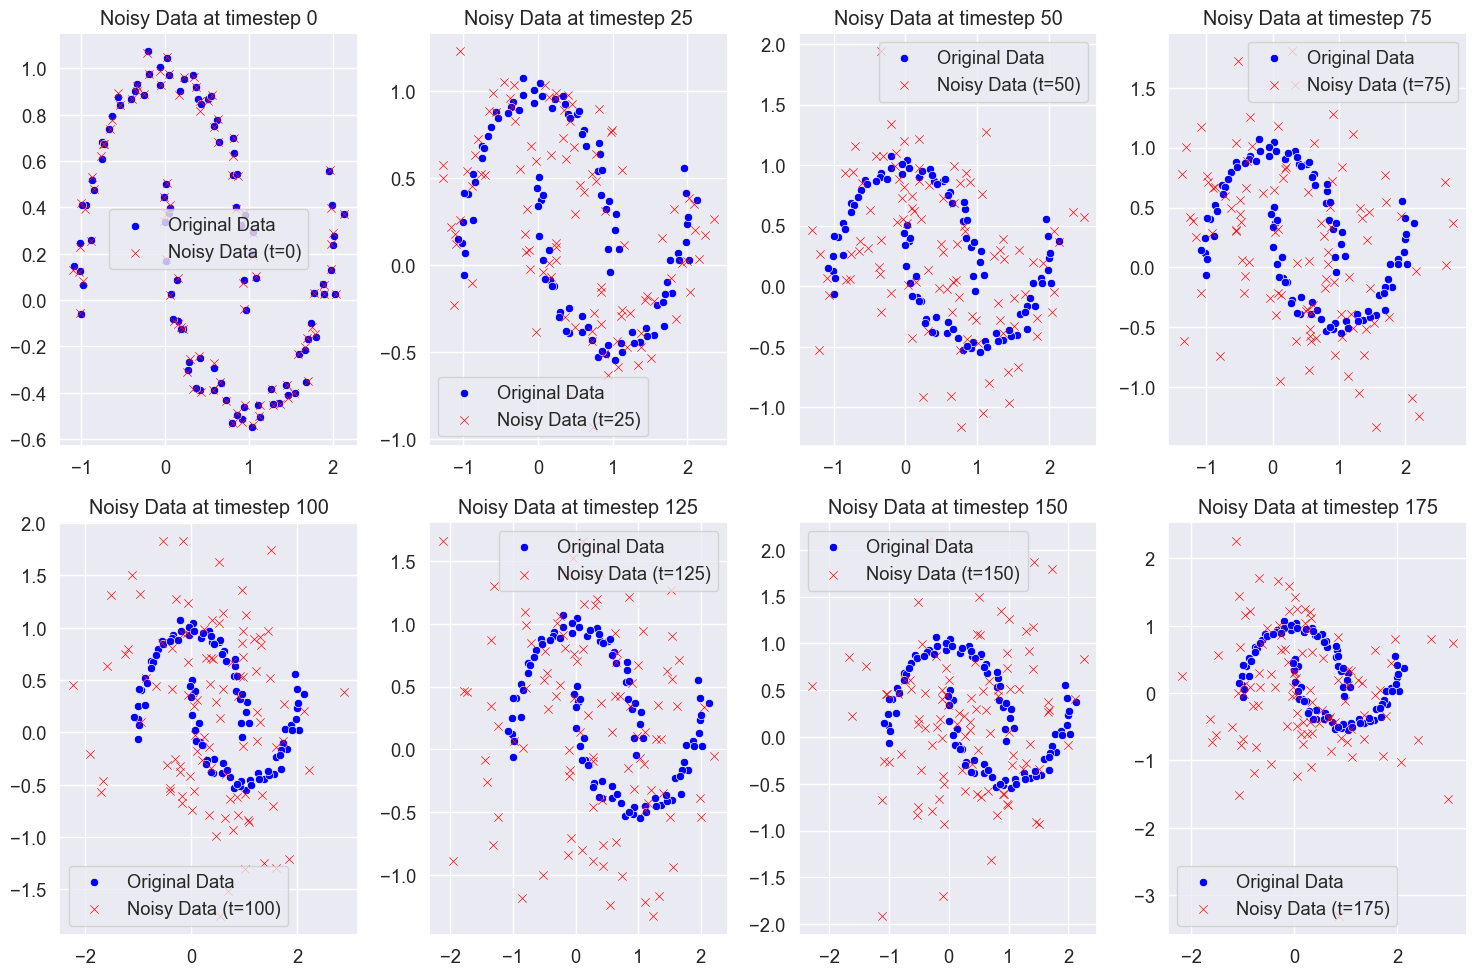

In [191]:
## Visualise a forwards diffusion

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the moons dataset
X, _ = make_moons(n_samples=100, noise=0.05, random_state=42)
X = torch.tensor(X, device=device)

# Create an instance of the diffusion model -- use defualt settings in this case
D = Diffuser(device=device)

# Calculate the number of rows and columns for subplots
plot_every = 25  # Plot every 10th timestep
num_timesteps = D.T
num_plots = num_timesteps // plot_every
num_cols = min(4, num_plots)  # Maximum of 2 columns
num_rows = (num_plots - 1) // num_cols + 1

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Sample noisy data points from the DDM at every 10th timestep and create subplots
for t in range(num_timesteps):
    if t % plot_every == 0:  # Plot every 10th timestep
        noisy_data, _ = D.forwards_diffusion(X, t)
        plot_num = t // plot_every
        row = plot_num // num_cols
        col = plot_num % num_cols

        # Convert noisy_data to CPU tensor for plotting
        noisy_data_cpu = noisy_data.cpu()
        print(noisy_data_cpu.shape)

        # Scatter plots using Seaborn
        sns.scatterplot(x=X[:, 0].cpu().numpy(), y=X[:, 1].cpu().numpy(), color='blue', marker='o', label='Original Data', ax=axs[row, col])
        sns.scatterplot(x=noisy_data_cpu[:, 0].numpy(), y=noisy_data_cpu[:, 1].numpy(),
                        color='red', marker='x', label=f'Noisy Data (t={t})', ax=axs[row, col])
        
        axs[row, col].set_title(f'Noisy Data at timestep {t}')
        axs[row, col].legend()

plt.tight_layout()
plt.show()

/home/pr478@ad.eng.cam.ac.uk/anaconda3/envs/score_based_flows/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Epoch [1]:   0%|          | 0/100 [00:00<?, ?it/s]

/home/pr478@ad.eng.cam.ac.uk/anaconda3/envs/score_based_flows/lib/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [2]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11]:   0%|          | 0/100 [00:00<?, ?it/s]

/home/pr478@ad.eng.cam.ac.uk/anaconda3/envs/score_based_flows/lib/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [12]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [16]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [17]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [18]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [19]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [20]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [21]:   0%|          | 0/100 [00:00<?, ?it/s]

/home/pr478@ad.eng.cam.ac.uk/anaconda3/envs/score_based_flows/lib/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [22]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [23]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [24]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [25]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [26]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [27]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [28]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [29]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [30]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [31]:   0%|          | 0/100 [00:00<?, ?it/s]

/home/pr478@ad.eng.cam.ac.uk/anaconda3/envs/score_based_flows/lib/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [32]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [33]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [34]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [35]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [36]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [37]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [38]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [39]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [40]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [41]:   0%|          | 0/100 [00:00<?, ?it/s]

/home/pr478@ad.eng.cam.ac.uk/anaconda3/envs/score_based_flows/lib/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [42]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [43]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [44]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [45]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [46]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [47]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [48]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [49]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [50]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [51]:   0%|          | 0/100 [00:00<?, ?it/s]

/home/pr478@ad.eng.cam.ac.uk/anaconda3/envs/score_based_flows/lib/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [52]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [53]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [54]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [55]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [56]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [57]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [58]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [59]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [60]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [61]:   0%|          | 0/100 [00:00<?, ?it/s]

/home/pr478@ad.eng.cam.ac.uk/anaconda3/envs/score_based_flows/lib/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [62]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [63]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [64]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [65]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [66]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [67]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [68]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [69]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [70]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [71]:   0%|          | 0/100 [00:00<?, ?it/s]

/home/pr478@ad.eng.cam.ac.uk/anaconda3/envs/score_based_flows/lib/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [72]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [73]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [74]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [75]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [76]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [77]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [78]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [79]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [80]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [81]:   0%|          | 0/100 [00:00<?, ?it/s]

/home/pr478@ad.eng.cam.ac.uk/anaconda3/envs/score_based_flows/lib/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [82]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [83]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [84]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [85]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [86]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [87]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [88]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [89]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [90]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [91]:   0%|          | 0/100 [00:00<?, ?it/s]

/home/pr478@ad.eng.cam.ac.uk/anaconda3/envs/score_based_flows/lib/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [92]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [93]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [94]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [95]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [96]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [97]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [98]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [99]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [100]:   0%|          | 0/100 [00:00<?, ?it/s]

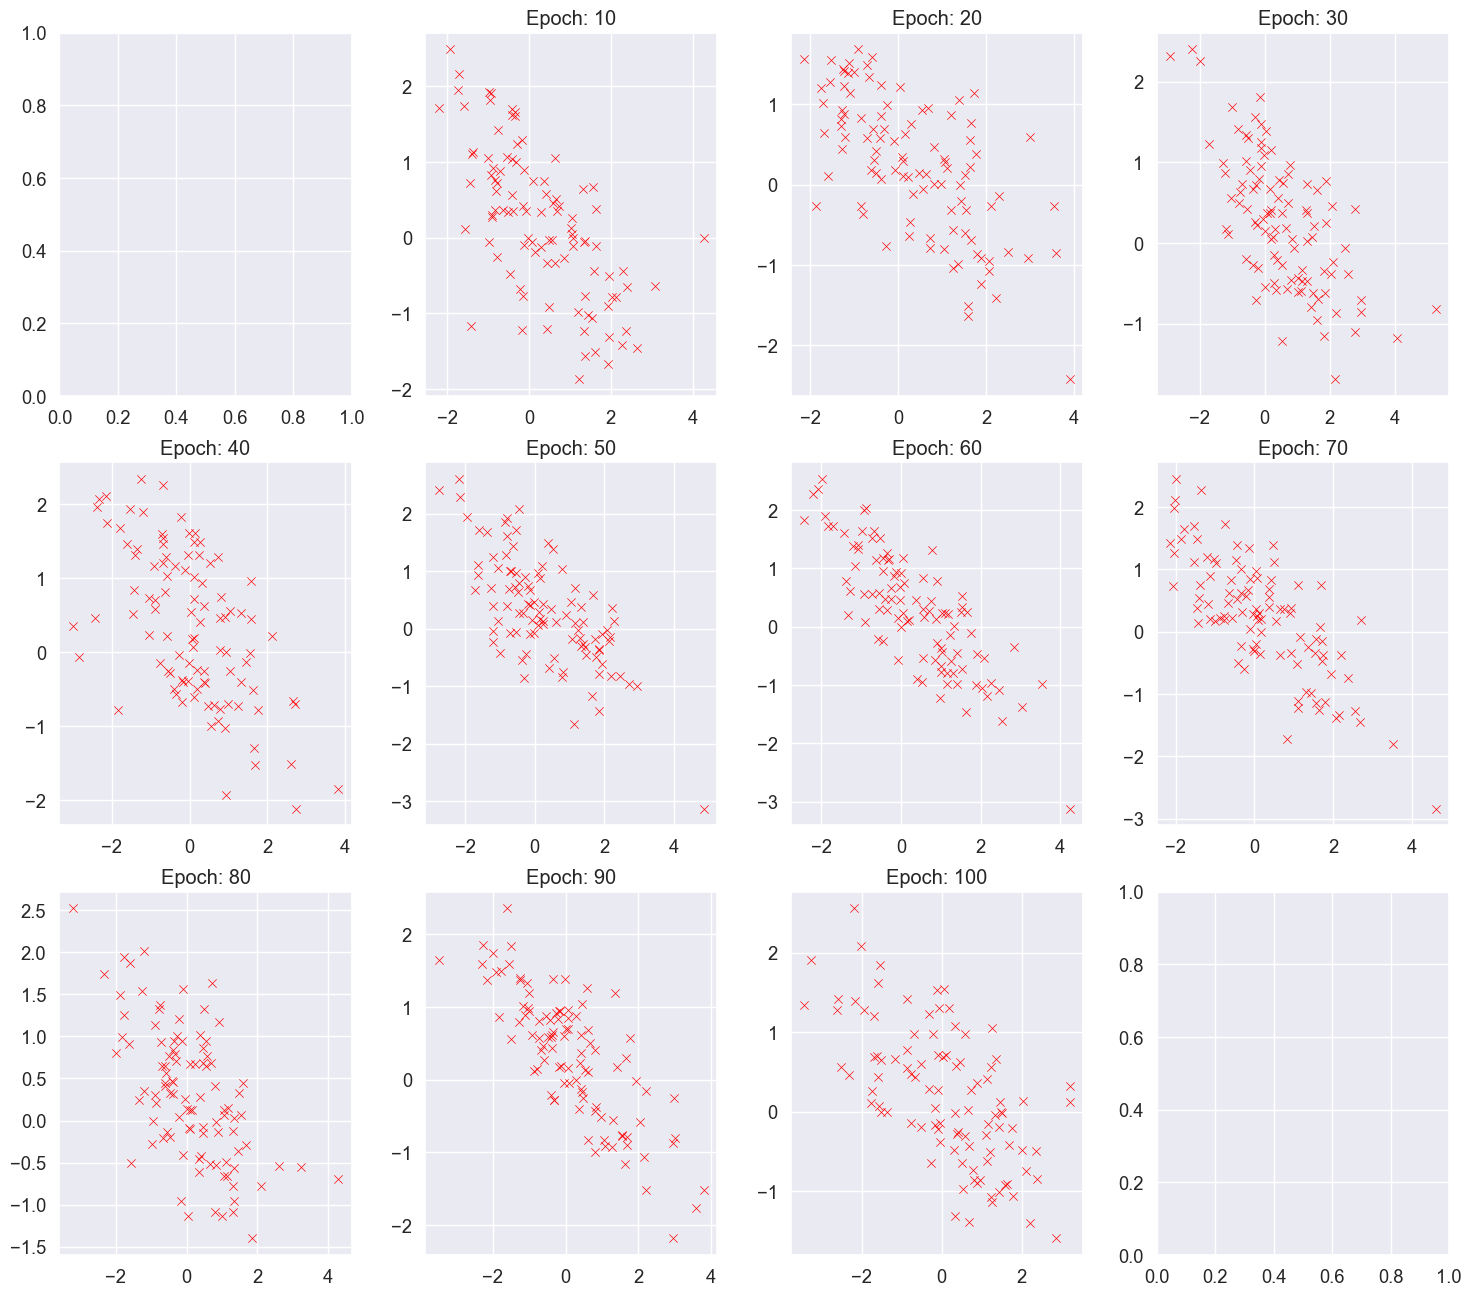

In [192]:
## Training and sampling

NUM_EPOCHS=100
LR=0.001 
TIMESTEPS=50 
shape = 1
net = NeuralNet(input_dim=2, output_dim=1, num_timesteps = D.T).to(device)
optimiser = torch.optim.Adam(net.parameters(), lr=LR, amsgrad=True)
loss_function = nn.MSELoss()

# Use loaded dataset
X.to(device)

# Create an instance of the diffusion model -- use defualt settings in this case
D = Diffuser(num_timesteps=TIMESTEPS, device=device)

# Calculate the number of rows and columns for subplots
sample_every = 10 # Plot every 10th timestep
num_timesteps = D.T
num_plots = (NUM_EPOCHS // sample_every)
num_cols = min(4, num_plots)  # Maximum of 2 columns
num_rows = (num_plots - 1) // num_cols + 1

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

for epoch in range(1, NUM_EPOCHS+1):
        avg_loss= D.training_step(model=net, 
                                  X=X, 
                                  optimiser=optimiser,
                                  loss_fn=loss_function,
                                  current_epoch=epoch)
        
        if epoch % sample_every == 0:
                with torch.no_grad():
                        # Sample from p(x_t) -> reverse diffuse

                        x0 = D.reverse_diffusion(model=net)
                        
                        plot_num = epoch // sample_every
                        row = plot_num // num_cols
                        col = plot_num % num_cols

                        # Plot x0 on the specified subplot
                        sns.scatterplot(x=x0[:, 0].cpu().numpy(), y=x0[:, 1].cpu().numpy(),
                        color='red', marker='x', ax=axs[row, col])

                        axs[row, col].set_title(f'Epoch: {epoch}')
                
# Adjust layout and show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()